In [1]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
#import matplotlib, copy, skimage, os, tifffile
from skimage import io, morphology, draw
import gdal
from PIL import Image
import random
import json
from tqdm import tqdm
import io
import glob
import shutil
import os

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
# modified to buffer the bounding boxes by 15 pixels
def get_labels(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    x_off = 15
    y_off = 15
    add_np = np.array([-x_off, -y_off, x_off, y_off])
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['IMAGE_ID']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes

In [5]:
fname = '../first_run_training_data.geojson'
coords, chips, classes = get_labels(fname)

100%|██████████| 13674/13674 [00:00<00:00, 151697.18it/s]


/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif


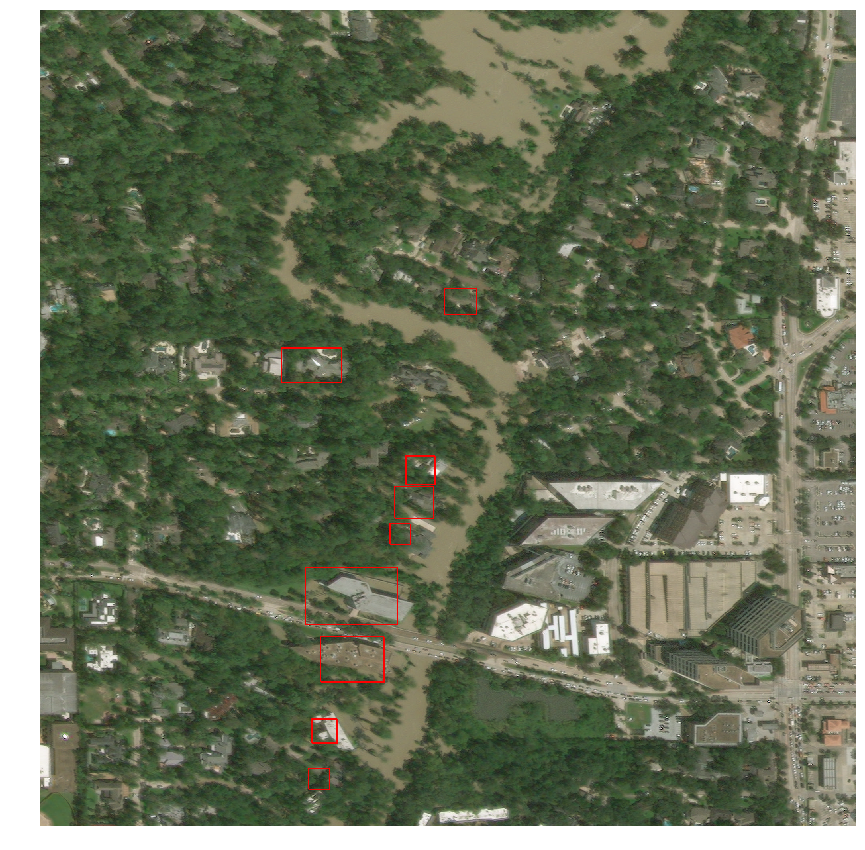

In [6]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'
chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
# print(coords_chip)

# add offsets
# x_off = 15
# y_off = 15
# add_np = np.array([-x_off, -y_off, x_off, y_off])
# coords_chip = np.add(coords_chip, add_np)

# CAUTION: should check the wether the shifted bboxes are within big image boundary

classes_chip = classes[chips==chip_name].astype(np.int64)
labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [19]:
# take absolut path of chip files
# converted to png files

def draw_bbox_on_tiff(chip_path, coords, chips, classes, save_path):
    #Load an image
    #path = '/home/ubuntu/anyan/harvey_data/converted_sample_tiff/'
    
    
    # big tiff name: chip name
    # init to {big_tiff_name : []}
    #big_tiff_dict = dict((k, []) for k in big_tiff_set)

    fnames = glob.glob(chip_path + "*.tif")
    i = 0
    for f in fnames:
        
        chip_name = f.split('/')[-1]
        chip_big_tiff_id_list = chip_name.split('_')[1:3]
        chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
        print(chip_big_tiff_id)
        #if chip_big_tiff_id not in set(big_tiff_dict.keys()):
         #   big_tiff_dict[chip_big_tiff_id] = list()
          #  big_tiff_dict[chip_big_tiff_id].append(chip_name)
        #else:
            
#         if len(big_tiff_dict[chip_big_tiff_id]) < 5:


           #big_tiff_dict[chip_big_tiff_id].append(chip_name)
        arr = wv.get_image(f)
#             print(arr.shape)
    #         plt.figure(figsize=(10,10))
    #         plt.axis('off')
    #         plt.imshow(arr)
        coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
        if coords_chip.shape[0] == 0:
            print('no bounding boxes for this image')
            continue
        classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
        labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
        print(chip_name)
#             plt.figure(figsize=(15,15))
#             plt.axis('off')
#             plt.imshow(labelled)
        subdir_name = save_path + chip_big_tiff_id
        if os.path.isdir(subdir_name):
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
        else:
            os.mkdir(subdir_name)
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
           


In [84]:
# path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'
# save_path =  '/home/ubuntu/anyan/harvey_data/bbox_debug_png/'
# draw_bbox_on_tiff(path, coords, chips, classes, save_path)

In [85]:
# coords = coords[chips==chip_name]
# classes = classes[chips==chip_name].astype(np.int64)

In [86]:
print(classes)

[1. 1. 1. ... 2. 2. 2.]


[[ 703. 1571.  862. 1685.]
 [1013.  697. 1094.  762.]
 [ 605.  847.  756.  934.]
 [ 917. 1118.  990. 1190.]
 [ 889. 1194.  986. 1275.]
 [ 877. 1288.  928. 1339.]
 [ 665. 1397.  896. 1541.]
 [ 672. 1902.  725. 1954.]
 [ 681. 1778.  744. 1838.]]
[1 1 1 1 1 1 1 1 1]


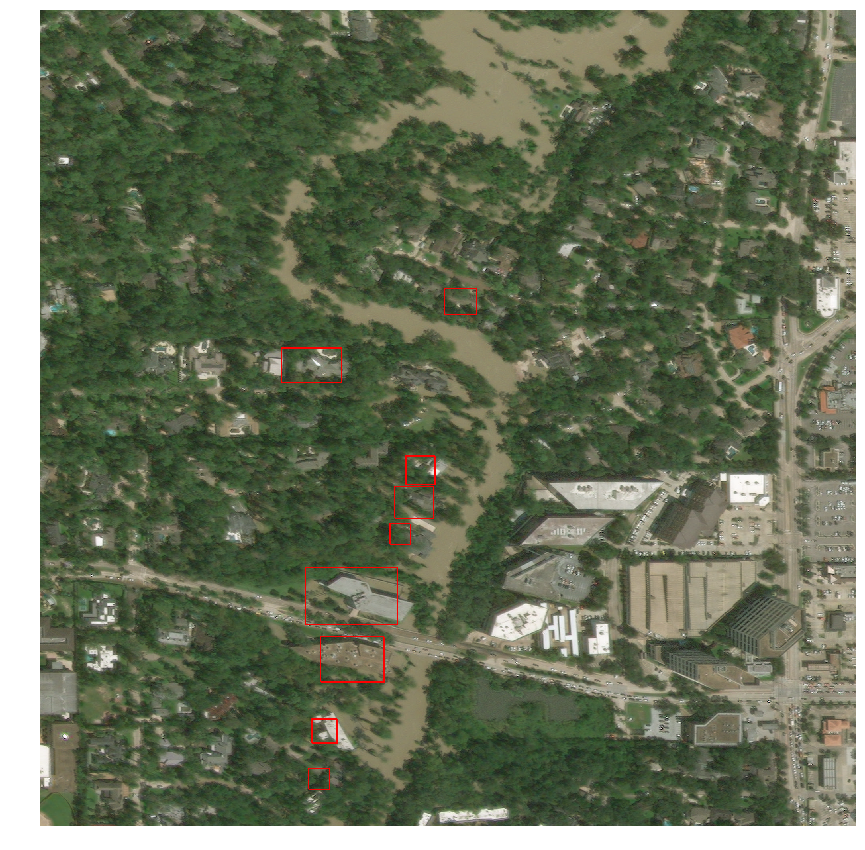

In [7]:
coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
print(coords_chip)
classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
print(classes_chip)
labelled = aug.draw_bboxes(arr,coords_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

In [90]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords_chip, classes=classes_chip, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 4


In [91]:
len(c_box[2])

1

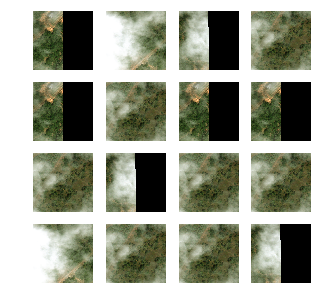

In [109]:
#We can plot some of the chips
fig,ax = plt.subplots(4)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

In [110]:
# detect black blocks in an image
# take an img in array format
# determine whether the area of the black portion is larger than a threshold: 0.1
# return True if the img contain large portions of black 


def detect_blackblock(img):
    # check the # of pixels that with RGB values are all equal to 0
    w,h,c = img.shape
    black_pixel_count=0
    threshold = 0.1 * w * h
    
    for i in range(w):
        for j in range(h):
#             print()
            #if img[i,j,0]== 0 and img[i,j,1]== 0 and img[i,j,2]== 0:
            if np.all(img[i,j,:] ==0):
                black_pixel_count+=1
                if black_pixel_count > threshold:
                    return True
    return False
                

    

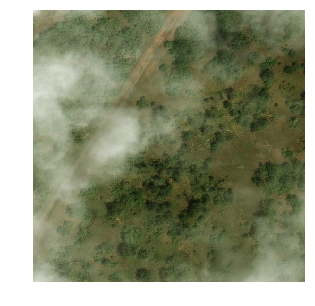

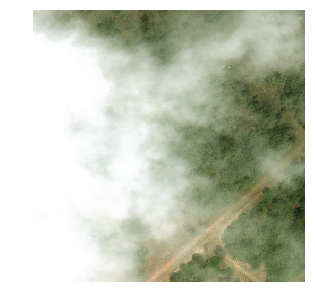

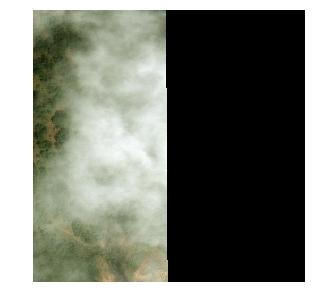

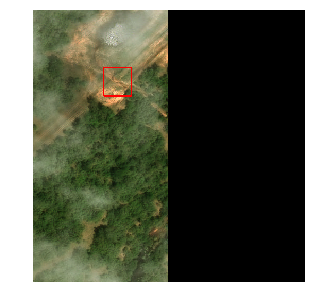

In [112]:
#We can visualize the chips with their labels
for ind in range(0, c_img.shape[0]):
    #ind = np.random.choice(range(c_img.shape[0]))
#     if detect_blackblock(c_img[ind]): # contain black, ignore
#         continue
    labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(labelled)

In [106]:
detect_blackblock(arr)

True

In [94]:




# labelled = aug.draw_bboxes(arr,coords[classes ==1])
# plt.figure(figsize=(15,15))
# plt.axis('off')
# plt.imshow(labelled)

In [95]:
# labelled.save("test.png")